In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

In [10]:
# load dataset
df = pd.read_csv('../data/final_stats.csv')
df.head()

,Player,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,T_DRB,T_TRB,T_AST,T_STL,T_BLK,T_TOV,T_PF,T_PTS,W/L%,Share
0,Shawn Marion,34,67,67,30.0,5.3,10.3,0.514,0.3,1.1,...,379,525,163,75,47,103,111,812,0.500,0.000
1,O.J. Mayo,25,82,82,35.5,5.6,12.5,0.449,1.7,4.3,...,255,291,361,93,23,210,195,1255,0.500,0.000
2,Dirk Nowitzki,34,53,47,31.3,6.5,13.7,0.471,1.2,3.0,...,326,363,132,38,37,70,93,917,0.500,0.000
3,Chris Bosh,28,74,74,33.2,6.6,12.3,0.535,0.3,1.0,...,370,501,123,66,101,128,168,1232,0.805,0.000
4,LeBron James,28,76,76,37.9,10.1,17.8,0.565,1.4,3.3,...,513,610,551,129,67,226,110,2036,0.805,0.998


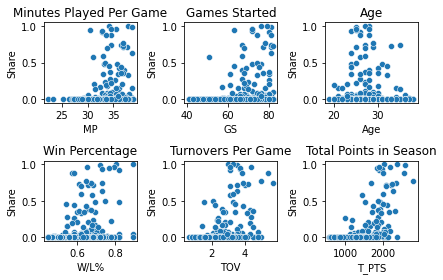

In [26]:
# correlations between individual features and target MVP Share
titles = ['Minutes Played Per Game', 'Games Started', 'Age', 'Win Percentage', 'Turnovers Per Game', 'Total Points in Season']
xs = ['MP', 'GS', 'Age', 'W/L%', 'TOV', 'T_PTS']

fig = plt.figure()
for i in range(6):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.title.set_text(titles[i])
    sns.scatterplot(x=df[xs[i]], y=df['Share'], ax=ax)
plt.tight_layout()
plt.show()

<Axes: >

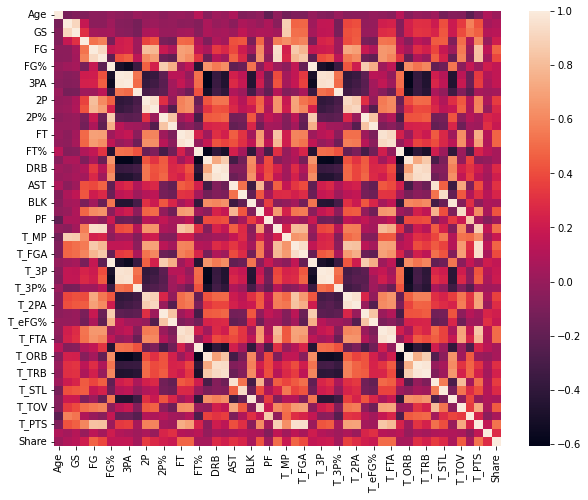

In [193]:
# correlation heatmap
corr_data = df.drop(['Player', 'Season'], axis=1)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_data.corr())

In [176]:
# tables to show overall model performance
mvp_stats = pd.DataFrame(columns=[
    'Season', 
    'MVP Actual',
    'Share Actual',
    'MVP OLS',
    'Share OLS',
    'MVP Random Forest',
    'Share Random Forest', 
    'MVP Gradient Boosting',
    'Share Gradient Boosting'
])

In [187]:
model_error = pd.DataFrame(columns=[
    'Model',
    'RMSE',
    'R2'
])

In [177]:
lm_rmse_scores = []
lm_r2_scores = []
rf_rmse_scores = []
rf_r2_scores = []
gb_rmse_scores = []
gb_r2_scores = []
gb_best_params = []

In [178]:
for i in range(12, 22):
    # training data will be all seasons except for one
    # testing data will be holdout season
    train = df[df['Season'] != i]
    test = df[df['Season'] == i]

    # training data
    X_train = train.drop(['Player', 'Season', 'Share'], axis=1)
    y_train = train['Share']

    # testing data
    X_test = test.drop(['Player', 'Season', 'Share'], axis=1)
    y_test = test['Share']

    # scale
    scaler = StandardScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_test_scale = scaler.transform(X_test)
    
    # reset index each iteration to for 
    test.reset_index(inplace=True)

    ## OLS regression model ##
    
    lm = LinearRegression()
    lm.fit(X_train_scale, y_train)
    
    # calculate model error metrics
    lm_rmse = np.mean(cross_val_score(lm, X_train_scale, y_train, scoring='neg_root_mean_squared_error'))
    lm_r2 = np.mean(cross_val_score(lm, X_train_scale, y_train, scoring='r2'))
    
    # add scores to respective lists for table later
    lm_rmse_scores.append(lm_rmse)
    lm_r2_scores.append(lm_r2)
    
    # make prediction using trained model
    lm_pred = lm.predict(X_test_scale)
    lm_ind = np.argmax(lm_pred)

    ## random forest regressor ##
    
    rf = RandomForestRegressor()
    rf.fit(X_train_scale, y_train)
    
    # calculate model error metrics
    rf_rmse = np.mean(cross_val_score(rf, X_train_scale, y_train, scoring='neg_root_mean_squared_error'))
    rf_r2 = np.mean(cross_val_score(rf, X_train_scale, y_train, scoring='r2'))
    
    # add scores to respective lists for table later
    rf_rmse_scores.append(rf_rmse)
    rf_r2_scores.append(rf_r2)
    
    # make prediction using trained model
    rf_pred = rf.predict(X_test_scale)
    rf_ind = np.argmax(rf_pred)

    ## gradient boosting regressor ##
    
    params = {
        'learning_rate': (0.05, 0.1, 0.5, 1.0),
        'n_estimators': range(100, 500, 100),
        'max_depth': range(1, 4)
    }
    gb = GradientBoostingRegressor()
    
    # find most successful combination of hyperparameters for model using GridSearchCV
    gs = GridSearchCV(gb, params, scoring='neg_root_mean_squared_error')
    gs.fit(X_train_scale, y_train)
    
    # fit model with best parameter configuration
    gb = GradientBoostingRegressor(**gs.best_params_)
    
    # add best hyperparamters for current iteration to list
    gb_best_params.append(gs.best_params_)
    
    # calculate model error metrics
    gb_rmse = np.mean(cross_val_score(gs.best_estimator_, X_train_scale, y_train, scoring='neg_root_mean_squared_error'))
    gb_r2 = np.mean(cross_val_score(gs.best_estimator_, X_train_scale, y_train, scoring='r2'))
    
    # add scores to respective lists for table later
    gb_rmse_scores.append(gb_rmse)
    gb_r2_scores.append(gb_r2)
    
    # make prediction using trained model
    gb_pred = gs.best_estimator_.predict(X_test_scale)
    gb_ind = np.argmax(gb_pred)
    
    # add prediction data to table
    mvp_stats.loc[len(mvp_stats.index)] = [
        '\'{}-\'{}'.format(i, i + 1),
        test['Player'][test['Share'].idxmax()],
        test['Share'][test['Share'].idxmax()],
        test['Player'][lm_ind],
        round(lm_pred[lm_ind], 3),
        test['Player'][rf_ind],
        round(rf_pred[rf_ind], 3),
        test['Player'][gb_ind],
        round(gb_pred[gb_ind], 3)
    ]

In [179]:
mvp_stats

,Season,MVP Actual,Share Actual,MVP OLS,Share OLS,MVP Random Forest,Share Random Forest,MVP Gradient Boosting,Share Gradient Boosting
0,'12-'13,LeBron James,0.998,LeBron James,0.487,LeBron James,0.599,LeBron James,0.642
1,'13-'14,Kevin Durant,0.986,LeBron James,0.491,LeBron James,0.659,Kevin Durant,0.825
2,'14-'15,Stephen Curry,0.922,Stephen Curry,0.330,James Harden,0.334,Stephen Curry,0.537
3,'15-'16,Stephen Curry,1.000,Stephen Curry,0.564,Stephen Curry,0.637,Stephen Curry,0.801
4,'16-'17,Russell Westbrook,0.879,LeBron James,0.471,LeBron James,0.643,James Harden,0.710
5,'17-'18,James Harden,0.955,LeBron James,0.623,LeBron James,0.559,LeBron James,0.626
6,'18-'19,Giannis Antetokounmpo,0.932,Giannis Antetokounmpo,0.531,James Harden,0.640,Giannis Antetokounmpo,0.892
7,'19-'20,Giannis Antetokounmpo,0.952,Giannis Antetokounmpo,0.361,James Harden,0.678,James Harden,0.729
8,'20-'21,Nikola Jokić,0.961,Giannis Antetokounmpo,0.358,Nikola Jokić,0.579,Nikola Jokić,0.517
9,'21-'22,Nikola Jokić,0.875,Nikola Jokić,0.520,Nikola Jokić,0.671,Nikola Jokić,0.732


In [188]:
# populate model error metrics with averages over all seasons
model_error.loc[len(model_error.index)] = [
    'OLS',
    round(abs(np.mean(lm_rmse_scores)), 3),
    round(np.mean(lm_r2_scores), 3)
]
model_error.loc[len(model_error.index)] = [
    'Random Forest',
    round(abs(np.mean(rf_rmse_scores)), 3),
    round(np.mean(rf_r2_scores), 3)
]
model_error.loc[len(model_error.index)] = [
    'Gradient Boosting',
    round(abs(np.mean(gb_rmse_scores)), 3),
    round(np.mean(gb_r2_scores), 3)
]

model_error

,Model,RMSE,R2
0,OLS,0.129,0.364
1,Random Forest,0.107,0.544
2,Gradient Boosting,0.102,0.581


In [197]:
# chosen hyperparameters for each test set
# best choice -- {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 400}
gb_best_params

[{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 400},
 {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 400},
 {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300},
 {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 400},
 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 400},
 {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100},
 {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200},
 {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200},
 {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 400},
 {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300}]